<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Arch" data-toc-modified-id="Arch-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Arch</a></span></li><li><span><a href="#Loss" data-toc-modified-id="Loss-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Loss</a></span></li><li><span><a href="#Train" data-toc-modified-id="Train-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Train</a></span></li><li><span><a href="#Stepping-Through-a-Batch" data-toc-modified-id="Stepping-Through-a-Batch-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Stepping Through a Batch</a></span></li><li><span><a href="#Loss" data-toc-modified-id="Loss-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Loss</a></span></li></ul></div>

**~ JH's Code ~**

# Data

In [ ]:
### Imports & Paths ###
from fastai.vision.all import *
import pandas as pd


### Params ###
im_sz   = 224
bs      = 64
val_pct = .2
sub_pct = 1
path = untar_data(URLs.PASCAL_2007)
annos_path = path/'train.json'
ims_path = path/'train'


### Items ###
fns, annos = get_annotations(annos_path)
fn2anno = {f:a for f,a in zip(fns,annos)}
def get_im(f):   return ims_path/f
def get_bbox(f): return fn2anno[f][0]
def get_lbl(f):  return fn2anno[f][1]


### DataLoaders ###
tfmz = setup_aug_tfms([Rotate(), Brightness(), Contrast(), Flip(),
                       Normalize.from_stats(*imagenet_stats)])
db = DataBlock(
    blocks=[ImageBlock, BBoxBlock, BBoxLblBlock(add_na=False)],
    get_x=get_im, get_y=[get_bbox, get_lbl],
    splitter=RandomSplitter(val_pct),
    item_tfms=Resize(im_sz, method='squish'),
    batch_tfms=tfmz, n_inp=1)
subset = L(fns).shuffle()[0:int(len(fns)*sub_pct)]
dls = db.dataloaders(subset, bs=bs)
dls.v = dls.vocab
dls.ncls = len(dls.vocab)

In [ ]:
### Inspection ###
print("Vocab:", dls.v)
print("Size of train data:",len(dls.train.items))
print("Size of valid data:",len(dls.valid.items))
for i,t in enumerate(dls.one_batch()):
    print(f"batch[{i}]:",'\t',t.dtype,'\t',t.shape)

Vocab: (#20) ['aeroplane','bicycle','bird','boat','bottle','bus','car','cat','chair','cow'...]
Size of train data: 2001
Size of valid data: 500
batch[0]: 	 torch.float32 	 torch.Size([64, 3, 224, 224])
batch[1]: 	 torch.float32 	 torch.Size([64, 10, 4])
batch[2]: 	 torch.int64 	 torch.Size([64, 10])


Interpretation of tensor shapes:
- torch.Size([128, 3, 224, 224]): bs, channels (rgb), im_sz, im_sz
- torch.Size([128, 20, 4]): bs, max objs for a single im in batch, bb coords
- torch.Size([128, 20]): bs, max objs for a single im in batch

# Arch

In [ ]:
### Anchors ###
anc_grids = [4,2,1]
# anc_grids = [4]
anc_zooms = [0.75, 1., 1.3]
# anc_zooms = [1.]
anc_ratios = [(1.,1.), (1.,0.5), (0.5,1.)]
# anc_ratios = [(1.,1.)]
anchor_scales = [(anz*i,anz*j) for anz in anc_zooms for (i,j) in anc_ratios]
k = len(anchor_scales)
anc_offsets = [1/(o*2) for o in anc_grids]
anc_x = np.concatenate([np.tile(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_y = np.concatenate([np.repeat(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)
anc_sizes  =   np.concatenate([np.array([[o/ag,p/ag] for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids])
grid_sizes = tensor(np.concatenate([np.array([ 1/ag       for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids]), requires_grad=False).unsqueeze(1)
anchors = tensor(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()

def hw2corners(ctr, hw): return torch.cat([ctr-hw/2,ctr+hw/2], dim=1)
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])

In [ ]:
anchors.shape, anchors[100]

(torch.Size([189, 4]), tensor([0.8750, 0.6250, 0.1875, 0.0938]))

In [ ]:
### Architecture ###
class StdConv(nn.Module):
    def __init__(self, n_in,n_out,stride=2,dp = 0.1):
        super().__init__()
        self.conv = nn.Conv2d(n_in,n_out,3,stride=stride,padding=1)
        self.bn = nn.BatchNorm2d(n_out)
        self.dropout = nn.Dropout(dp)
        
    def forward(self,x):
        return self.dropout(self.bn(F.relu(self.conv(x))))
    
def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

class OutConv(nn.Module):
    def __init__(self, k, n_in, bias):
        super().__init__()
        self.k = k
        self.bbs  = nn.Conv2d(n_in,            4*k, 3, padding=1)
        self.lbls = nn.Conv2d(n_in, (dls.ncls+1)*k, 3, padding=1)
        self.lbls.bias.data.zero_().add_(bias)
        
    def forward(self,x):
        return [flatten_conv(self.bbs(x),  self.k),
                flatten_conv(self.lbls(x), self.k)]
    
drop=0.4
class SSD_MultiHead(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(drop)
        self.sconv1 = StdConv(512,256, dp=drop)
        self.sconv2 = StdConv(256,256, dp=drop)
        self.sconv3 = StdConv(256,256, dp=drop)
        self.out1 = OutConv(k, 256, bias)
        self.out2 = OutConv(k, 256, bias)
        self.out3 = OutConv(k, 256, bias)

    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv1(x)
        bbs1,lbls1 = self.out1(x)
        x = self.sconv2(x)
        bbs2,lbls2 = self.out2(x)
        x = self.sconv3(x)
        bbs3,lbls3 = self.out3(x)
        return [torch.cat([ bbs1, bbs2, bbs3], dim=1),
                torch.cat([lbls1,lbls2,lbls3], dim=1)]
    
class CustMod(Module):
    """A module made from a pretrained body and an untrained head."""
    def __init__(self, body, head):
        self.body, self.head = body, head
        
    def forward(self, x):
        return self.head(self.body(x))

# Loss

In [ ]:
### FocalLoss ###
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data].to('cuda')

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
    
    def forward(self, preds, targets):
        t = one_hot_embedding(targets, self.num_classes+1)
        t = tensor(t[:,:-1].contiguous())
        x = preds[:,:-1]
        w = self.get_weight(x,t).detach()
        return F.binary_cross_entropy_with_logits(x, t, w, reduction='sum') / self.num_classes
    
    def get_weight(self,x,t):
        return None

class FocalLoss(BCE_Loss):
    def get_weight(self,x,t):
        alpha,gamma = 0.25,2.
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return w * (1-pt).pow(gamma)

loss_f = FocalLoss(dls.ncls)

In [ ]:
### IoU ###
def intersection(box_a,box_b):
    min_xy = torch.max(box_a[:,None,:2],box_b[None,:,:2])
    max_xy = torch.min(box_a[:,None,2:],box_b[None,:,2:])
    inter = torch.clamp(max_xy-min_xy,min=0)
    return inter[:,:,0] * inter[:,:,1]

def get_size(box):
    return (box[:,2]-box[:,0]) * (box[:,3] - box[:,1])

def jaccard(box_a,box_b):
    inter = intersection(box_a,box_b)
    union = get_size(box_a).unsqueeze(1) + get_size(box_b).unsqueeze(0) - inter
    return inter/union

In [ ]:
### ssd_loss ###
def get_y(bbox,clas):
    bbox = bbox.view(-1,4)/size
    bb_keep = ((bbox[:,2] - bbox[:,0])>0.).nonzero()[:,0]
    return bbox[bb_keep], clas[bb_keep]
    
def actn_to_bb(actn, anchors):
    actn_bbs = torch.tanh(actn)
    actn_ctrs = (actn_bbs.cuda()[:,:2] * grid_sizes.cuda()/2) + anchors.cuda()[:,:2]
    actn_hw = (1 + actn_bbs.cuda()[:,2:]/2) * anchors.cuda()[:,2:]
    return hw2corners(actn_ctrs,actn_hw)

def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: print(prior_overlap)
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

def ssd_1_loss(b_bb, b_c, bbox, clas, print_it=False, use_ab=True):
    bbox,clas = get_y(bbox,clas)
    a_ic = actn_to_bb(b_bb, anchors)
    overlaps = jaccard(bbox.data, (anchor_cnr.cuda() if use_ab else a_ic).data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps)
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    gt_clas[~pos] = dls.ncls
    gt_bbox = bbox[gt_idx]
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    clas_loss  = loss_f(b_c, gt_clas)
    return loc_loss, clas_loss

def ssd_loss(pred, targ_bb, targ_lbl, print_it=True):
    bb_sum,lbl_sum = 0.,0.
    for pred_bb,pred_lbl,bbox,clas in zip(*pred,targ_bb,targ_lbl):
        bb_loss,lbl_loss = ssd_1_loss(pred_bb,pred_lbl,bbox,clas,print_it)
        bb_sum += bb_loss
        lbl_sum += lbl_loss
    if print_it: print(f"bb:{bb_sum:.02f} | lbl: {lbl_sum:.02f}")
    return bb_sum + lbl_sum

# Train

In [ ]:
size = im_sz
batch_size = bs
head_reg4 = SSD_MultiHead(k, -4.)
model = CustMod(create_body(resnet34, pretrained=True), head_reg4)

bb:10.85 | lbl: 4.43
bb:10.77 | lbl: 4.50
bb:11.00 | lbl: 4.56
bb:11.22 | lbl: 4.14
bb:11.11 | lbl: 4.46
bb:11.15 | lbl: 4.20
bb:10.91 | lbl: 4.51
bb:10.92 | lbl: 4.39
bb:10.94 | lbl: 4.25
bb:10.94 | lbl: 4.50
bb:10.70 | lbl: 4.48
bb:11.12 | lbl: 4.38
bb:10.61 | lbl: 4.61
bb:11.17 | lbl: 3.98
bb:10.87 | lbl: 4.70
bb:10.88 | lbl: 4.51
bb:10.75 | lbl: 4.17
bb:10.72 | lbl: 4.65
bb:10.76 | lbl: 4.36
bb:10.70 | lbl: 4.25
bb:10.56 | lbl: 4.34
bb:10.58 | lbl: 4.42
bb:10.72 | lbl: 4.47
bb:10.21 | lbl: 4.31
bb:10.38 | lbl: 4.48
bb:10.28 | lbl: 4.33
bb:10.33 | lbl: 4.49
bb:9.92 | lbl: 4.66
bb:9.71 | lbl: 4.37
bb:9.48 | lbl: 3.86
bb:9.28 | lbl: 4.30
bb:8.86 | lbl: 4.39
bb:8.32 | lbl: 4.47
bb:8.17 | lbl: 4.10
bb:7.53 | lbl: 4.13
bb:7.02 | lbl: 4.30
bb:6.70 | lbl: 4.21
bb:6.02 | lbl: 3.94
bb:5.93 | lbl: 4.00
bb:5.69 | lbl: 4.27
bb:5.39 | lbl: 3.77
bb:5.39 | lbl: 4.18
bb:5.12 | lbl: 3.64
bb:5.10 | lbl: 3.52
bb:4.99 | lbl: 3.09
bb:4.93 | lbl: 3.36
bb:4.86 | lbl: 3.07
bb:4.87 | lbl: 2.59
bb:4.89 | lbl

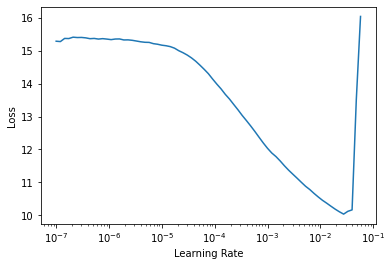

In [ ]:
learner = Learner(dls, model, loss_func=ssd_loss).to_fp16()
learner.freeze()
lr_min, lr_steep = learner.lr_find()

In [ ]:
lr = (lr_min+lr_steep)/2; print("lr:",round(lr,4))

lr: 0.0017


In [ ]:
learner.fit_one_cycle(5, lr=lr)

epoch,train_loss,valid_loss,time
0,8.574489,6.161962,00:09
1,7.015879,5.887607,00:09
2,6.400682,5.772642,00:09
3,6.044405,5.686826,00:09
4,5.821069,5.673601,00:09


bb:11.00 | lbl: 4.37
bb:10.50 | lbl: 4.40
bb:9.53 | lbl: 4.34
bb:8.55 | lbl: 4.60
bb:8.33 | lbl: 4.23
bb:7.62 | lbl: 4.38
bb:7.09 | lbl: 4.28
bb:6.47 | lbl: 4.02
bb:5.93 | lbl: 3.89
bb:5.58 | lbl: 3.99
bb:5.33 | lbl: 4.02
bb:5.28 | lbl: 3.56
bb:5.14 | lbl: 3.51
bb:5.03 | lbl: 3.52
bb:4.94 | lbl: 3.38
bb:4.92 | lbl: 3.06
bb:4.95 | lbl: 2.72
bb:4.88 | lbl: 2.65
bb:4.87 | lbl: 2.13
bb:4.89 | lbl: 2.03
bb:4.76 | lbl: 1.98
bb:4.83 | lbl: 2.01
bb:4.86 | lbl: 2.07
bb:4.90 | lbl: 2.02
bb:4.88 | lbl: 2.09
bb:4.90 | lbl: 2.06
bb:4.86 | lbl: 1.93
bb:4.83 | lbl: 1.80
bb:4.81 | lbl: 1.81
bb:4.85 | lbl: 1.89
bb:4.83 | lbl: 1.80
bb:4.90 | lbl: 1.28
bb:4.86 | lbl: 1.46
bb:4.82 | lbl: 1.36
bb:4.81 | lbl: 1.42
bb:4.81 | lbl: 1.62
bb:4.86 | lbl: 1.44
bb:4.87 | lbl: 1.35
bb:3.96 | lbl: 1.32
bb:4.90 | lbl: 1.56
bb:4.85 | lbl: 1.69
bb:4.87 | lbl: 1.42
bb:4.81 | lbl: 1.49
bb:4.82 | lbl: 1.58
bb:4.87 | lbl: 1.46
bb:4.88 | lbl: 1.63
bb:4.90 | lbl: 1.39
bb:4.84 | lbl: 1.40
bb:4.86 | lbl: 1.47
bb:4.84 | lbl: 1.1

In [ ]:
learner.save('s1')

Path('models/s1.pth')

In [ ]:
learner.export('models/20201214_pascal2007_jh.pkl')

# Stepping Through a Batch

In [ ]:
# Get batch, acts
head_reg4 = SSD_MultiHead(k, -4.)
mod = CustMod(create_body(resnet34, pretrained=True), head_reg4)
mod.cpu().eval()

batch = next(iter(dls.cpu().valid))
acts = mod(batch[0])
batch_bbs, batch_lbls = batch[1], batch[2]

In [ ]:
# Get acts and targs for a single im
bidx = 0
act_bbs,act_lbls,bbs,lbls = list(zip(*acts,batch_bbs,batch_lbls))[bidx]